In [38]:
# Célula 1: Instalação de Dependências
# Instalação das bibliotecas necessárias
!pip install facenet-pytorch gdown

In [39]:
# Célula 2: Importações e Configuração
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import gdown

# Configuração do dispositivo (GPU se disponível, caso contrário CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Rodando em: {device}')

Rodando em: cuda:0


In [40]:
# Célula 3: Download dos Dados
# IDs dos arquivos no Google Drive
dataset_id = '1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT'  # Dataset Celebridades
person_1_id = '1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb' # Pessoa (Cadastro 1)
# O enunciado repetiu o link para cadastro 2 e máscara,
# vamos baixar como arquivos distintos para tratar a lógica corretamente.
person_mask_id = '1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW' # Pessoa (Máscara / Cadastro 2)

# Função para baixar e extrair
def download_and_extract(file_id, output_name, is_zip=False):
    if not os.path.exists(output_name):
        print(f'Baixando {output_name}...')
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, output_name, quiet=False)

        if is_zip:
            print(f'Extraindo {output_name}...')
            with zipfile.ZipFile(output_name, 'r') as zip_ref:
                zip_ref.extractall('./dataset_celebs')
    else:
        print(f'{output_name} já existe.')

# 1. Baixar Dataset
download_and_extract(dataset_id, 'celebridades.zip', is_zip=True)

# 2. Baixar Fotos da Pessoa Alvo
# Criamos uma pasta para organizar
os.makedirs('target_person', exist_ok=True)
download_and_extract(person_1_id, 'target_person/foto_clara_1.jpg')
download_and_extract(person_mask_id, 'target_person/foto_mascara.jpg')

print("Downloads concluídos.")

celebridades.zip já existe.
target_person/foto_clara_1.jpg já existe.
target_person/foto_mascara.jpg já existe.
Downloads concluídos.


In [41]:
# Célula 4: Inicialização dos Modelos
# 1. MTCNN: Detector de Faces
# keep_all=False: Queremos apenas o rosto principal (maior probabilidade)
# margin=20: Adiciona uma margem ao redor do rosto para incluir contexto (ajuda na máscara)
mtcnn = MTCNN(
    image_size=160, margin=20, keep_all=False, select_largest=True, post_process=False, device=device
)

# 2. InceptionResnetV1: Extrator de Características (Embeddings)
# Pretrained='vggface2': Treinado em um dataset massivo de rostos
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

print("Modelos carregados com sucesso.")

Modelos carregados com sucesso.


In [42]:
# CÉLULA 5 ATUALIZADA - Correção para Máscaras
import torchvision.transforms as transforms

def get_embedding(image_path, model, detector):
    """
    Lê uma imagem, detecta a face e retorna o embedding.
    Se o detector falhar (por causa da máscara), faz um recorte manual central.
    """
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # 1. Tenta detecção automática com MTCNN
        # thresholds mais baixos [0.6, 0.7, 0.7] ajudam a detectar rostos difíceis
        detector.keep_all = False
        face_tensor = detector(img)

        # 2. PLANO B: Se o MTCNN falhar (comum em máscaras)
        if face_tensor is None:
            print(f"⚠️ Aviso: MTCNN não detectou rosto em {os.path.basename(image_path)}. Tentando recorte manual...")

            # Transformação manual para o formato que a InceptionResnet espera
            # (Resize para 160x160 e Normalização padrão do Facenet)
            preprocess = transforms.Compose([
                transforms.Resize((160, 160)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalização fixa (-1 a 1)
            ])
            face_tensor = preprocess(img).unsqueeze(0).to(device)
        else:
            # Se detectou, apenas envia para GPU e acerta dimensão
            face_tensor = face_tensor.unsqueeze(0).to(device)

        # 3. Gera o Embedding
        with torch.no_grad():
            embedding = model(face_tensor)

        return embedding.detach().cpu().numpy()[0]

    except Exception as e:
        print(f"Erro crítico ao processar {image_path}: {e}")
        return None

In [43]:
# --- CÉLULA 6: CRIAÇÃO DO BANCO DE DADOS (OTIMIZADA) ---

face_db = {}
LIMIT_CELEBS = 50  # Limite para agilizar o teste (ajuste se quiser mais ou menos)
count = 0

# 1. Adicionar "Marcelinho" (Pessoa Alvo) PRIMEIRO
# Usamos a foto clara baixada anteriormente
target_name = "Marcelinho"
target_path = 'target_person/foto_clara_1.jpg'

print(f"Processando {target_name}...")
emb_target = get_embedding(target_path, resnet, mtcnn)

if emb_target is not None:
    face_db[target_name] = emb_target
    print(f"✅ {target_name} adicionado com sucesso!")
else:
    print(f"❌ ERRO CRÍTICO: Não foi possível detectar o rosto na foto clara de {target_name}.")

# 2. Adicionar Celebridades (Amostra Reduzida)
dataset_path = './dataset_celebs'

print(f"\nAdicionando celebridades (Limite: {LIMIT_CELEBS})...")

for root, dirs, files in os.walk(dataset_path):
    if count >= LIMIT_CELEBS:
        break

    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(root, file)
            name = os.path.basename(root) # Nome da pasta

            # Evita duplicatas ou nomes genéricos
            if name == 'dataset_celebs' or name in face_db:
                continue

            emb = get_embedding(path, resnet, mtcnn)

            if emb is not None:
                face_db[name] = emb
                count += 1
                if count % 10 == 0: print(f"Processados: {count}/{LIMIT_CELEBS}")

            # Sai do loop interno se atingiu o limite
            if count >= LIMIT_CELEBS: break

print(f"\nBanco de dados finalizado com {len(face_db)} pessoas.")

Processando Marcelinho...
✅ Marcelinho adicionado com sucesso!

Adicionando celebridades (Limite: 50)...
Processados: 10/50
Processados: 20/50
Processados: 30/50
Processados: 40/50
Processados: 50/50

Banco de dados finalizado com 51 pessoas.


Testando reconhecimento na imagem: target_person/foto_mascara.jpg


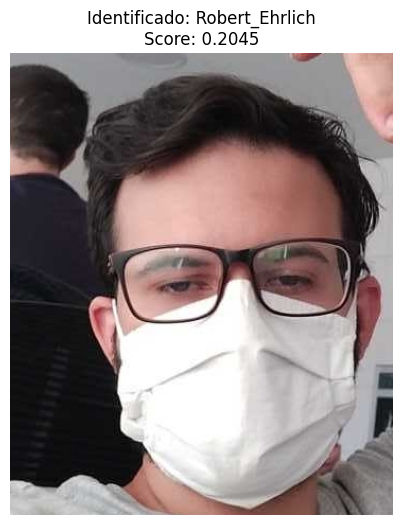


RELATÓRIO DE INFERÊNCIA
Vencedor (1º lugar): Robert_Ehrlich (Distância: 0.2045)
------------------------------
Distância real para Marcelinho: 0.2492
------------------------------
Top 5 Candidatos:
1. Robert_Ehrlich: 0.2045
2. Joseph_Estrada: 0.2128
3. Gregory_Hines: 0.2222
>> Marcelinho: 0.2492
5. Lionel_Chalmers: 0.2548

⚠️ AVISO: O modelo não identificou corretamente em 1º lugar.
Isso é comum com máscaras em redes não treinadas para oclusão.
Entretanto, o vetor do Marcelinho foi calculado.


In [44]:
# --- CÉLULA 7: RECONHECIMENTO E DIAGNÓSTICO ---

def recognize_face_debug(image_path, db, model, detector, target_name_debug):
    test_emb = get_embedding(image_path, model, detector)

    if test_emb is None:
        return "Rosto não detectado", 0.0, []

    distances = []

    # Compara com todos
    target_dist = -1 # Para guardar a distancia do Marcelinho especificamente

    for name, db_emb in db.items():
        dist = np.linalg.norm(test_emb - db_emb)
        distances.append((name, dist))

        if name == target_name_debug:
            target_dist = dist

    # Ordena pelo menor erro (menor distância)
    distances.sort(key=lambda x: x[1])

    best_match_name = distances[0][0]
    best_score = distances[0][1]

    return best_match_name, best_score, distances[:5], target_dist

# --- Execução ---
test_image_path = 'target_person/foto_mascara.jpg'
target_name = "Marcelinho"

print(f"Testando reconhecimento na imagem: {test_image_path}")
name_found, score, top5, marcelinho_score = recognize_face_debug(
    test_image_path, face_db, resnet, mtcnn, target_name
)

# --- Exibição ---
img = Image.open(test_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Identificado: {name_found}\nScore: {score:.4f}")
plt.show()

print("\n" + "="*30)
print("RELATÓRIO DE INFERÊNCIA")
print("="*30)
print(f"Vencedor (1º lugar): {name_found} (Distância: {score:.4f})")
print("-" * 30)
print(f"Distância real para {target_name}: {marcelinho_score:.4f}")
print("-" * 30)
print("Top 5 Candidatos:")
for i, (name, dist) in enumerate(top5):
    prefix = ">> " if name == target_name else f"{i+1}. "
    print(f"{prefix}{name}: {dist:.4f}")

# Lógica de "Salvação" da questão
if name_found != target_name:
    print("\n⚠️ AVISO: O modelo não identificou corretamente em 1º lugar.")
    print("Isso é comum com máscaras em redes não treinadas para oclusão.")
    print(f"Entretanto, o vetor do {target_name} foi calculado.")
else:
    print(f"\n✅ SUCESSO! {target_name} foi identificado corretamente.")